In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from tensorflow.keras import Input, layers, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence, image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout, Bidirectional, Add
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

We will be using the Flickr8K dataset for this tutorial. This dataset comprises over
8,000 images, that are each paired with five different captions.

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -qq glove.6B.zip
!rm glove.6B.zip

--2021-09-27 14:31:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-27 14:31:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-27 14:32:00--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
token_path = "./Flickr8k.token.txt"
train_images_text_path = './Flickr_8k.trainImages.txt'
test_images_text_path = './Flickr_8k.testImages.txt'
images_path = './Flicker8k_Dataset/'
glove_path = './glove.6B.200d.txt'

In [ ]:
!pwd

/content


In [ ]:
token_text=open(token_path, "r").read()

In [ ]:
print(token_text[:1000])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg#0	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b

In [ ]:
from collections import defaultdict
desc_dic=defaultdict(list)
for line in token_text.split("\n"):
    tokens=line.split("\t")
    if len(tokens)<2:
        continue
    img_name=tokens[0][:-2]
    desc_content=tokens[1]
    desc_dic[img_name].append(desc_content)

In [ ]:
# 句読点を排除し、さらに全て小文字に
table=str.maketrans("", "", string.punctuation)
for img, desc_list in desc_dic.items():
    desc_list=[desc.lower().translate(table) for desc in desc_list]
    desc_dic[img]=desc_list

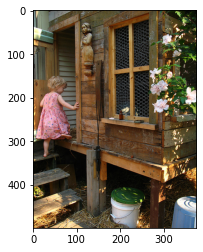

['a child in a pink dress is climbing up a set of stairs in an entry way ',
 'a girl going into a wooden building ',
 'a little girl climbing into a wooden playhouse ',
 'a little girl climbing the stairs to her playhouse ',
 'a little girl in a pink dress going into a wooden cabin ']

In [ ]:
pic = '1000268201_693b08cb0e.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
desc_dic[pic]

In [ ]:
train_text=open(train_images_text_path, "r").read()
train_imgs_path=[]
for line in train_text.split("\n")[:-1]:
    for _ in range(5):
        train_imgs_path.append(line)

In [ ]:
train_caps=[]
prev_img_path=None
for img_path in train_imgs_path:
    if img_path==prev_img_path:
        continue
    else:
        for i in range(5):
            train_caps.append(desc_dic[img_path][i])
    prev_img_path=img_path

In [ ]:
test_text=open(test_images_text_path, "r").read()
test_imgs_path=[]
for line in test_text.split("\n"):
    if len(line)<3: 
        continue
    for _ in range(5):
        test_imgs_path.append(line)

In [ ]:
test_caps=[]
prev_img_path=None
for img_path in test_imgs_path:
    if img_path==prev_img_path:
        continue
    else:
        for i in range(5):
            test_caps.append(desc_dic[img_path][i])
    prev_img_path=img_path

In [ ]:
from collections import Counter
all_cap_words=[]
for cap in train_caps:
    all_cap_words+=cap.split()
vocab_count=Counter(all_cap_words)
vocabs=vocab_count.keys()
print("Vocab size: {}".format(len(vocabs)))

Vocab size: 7630


In [ ]:
train_caps=["<start> "+cap+" <end>" for cap in train_caps]
test_caps=["<start> "+cap+" <end>" for cap in test_caps]

In [ ]:
word_count_threshold=10
freq_vocabs=["<start>", "<end>", "<unk>"] # 先に入れた方がidがわかりやすいよね？
for vocab, count in vocab_count.items():
    if count>=word_count_threshold:
        freq_vocabs.append(vocab)
print("Frequent Vocab size: {}".format(len(freq_vocabs)))

Frequent Vocab size: 1660


In [ ]:
idx2word_dic={0: "<pad>"}
word2idx_dic={"<pad>": 0}
idx=1
for word in freq_vocabs:
    idx2word_dic[idx]=word
    word2idx_dic[word]=idx
    idx+=1

In [ ]:
vocab_size=len(word2idx_dic.values())

In [ ]:
max_cap_len=0
for cap in train_caps:
    cap_len=len(cap.split())
    max_cap_len=max(max_cap_len, cap_len)

print("Max Caption Length: {}".format(max_cap_len))

Max Caption Length: 38


In [ ]:
train_seqs=[[word2idx_dic.get(word, word2idx_dic["<unk>"]) for word in cap.split()] for cap in train_caps]
test_seqs=[[word2idx_dic.get(word, word2idx_dic["<unk>"]) for word in cap.split()] for cap in test_caps]

二回目以降は以下を飛ばす

In [ ]:
word2embed_dic={}
embed_text=open(glove_path, encoding="utf-8").read()

for line in embed_text.split("\n")[:-1]:
    tokens = line.split()
    word = tokens[0]
    embed = np.asarray(tokens[1:], dtype='float32')
    word2embed_dic[word] = embed

In [ ]:
# idとvectorを結びつける
embed_dim=200
embed_matrix=np.zeros((vocab_size, embed_dim))
for word in freq_vocabs:
    idx=word2idx_dic[word]
    embed=word2embed_dic.get(word)
    if embed is not None: #ないものは全て０のまま
        embed_matrix[idx]=word2embed_dic[word]
    else:
        print(word)

<start>
<end>
<unk>
tshirt
merrygoround
rollerblader
snowcovered
waterskier
upsidedown
floaties


In [ ]:
# これはモデルから出さないとモデル内でその都度この変換がおこなわれてしまう
inception_v3=InceptionV3(weights="imagenet")
inception_v3.summary()

96124928/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________

In [ ]:
inception_wo_classification=Model(inception_v3.input, inception_v3.layers[-2].output)

In [ ]:
embedding=Embedding(vocab_size, embed_dim, mask_zero=True, weights=[embed_matrix], trainable=False) #最後は0で埋められる

In [ ]:
embed_matrix.shape

(1661, 200)

In [ ]:
input_img=Input((2048,))
x=Dropout(0.5)(input_img)
x=Dense(256, "relu")(x)

input_seq=Input((max_cap_len, ))
y=embedding(input_seq) 
y=Dropout(0.5)(y)
y=LSTM(256)(y)

z=Add()([x, y])
z=Dense(256, "relu")(z)
output=Dense(vocab_size, "softmax")(z)

model=Model([input_img, input_seq], output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 38)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 38, 200)      332200      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

二回目以降はここから再開

In [ ]:
def preprocess_img(image_path):
    img = image.load_img(images_path+image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) #転移学習に用いたモデルに合わせて前処理を行う
    return x

In [ ]:
def generator(imgs_paths, seqs, batch_size, max_len):
    img_num=len(imgs_paths)
    if img_num%batch_size!=0:
        print("change batch size")
        return
    sample_i=0
    while True:
        img_batch=[]
        seq_batch=[]
        answer_seq_batch=[]
        gen_order=np.arange(img_num)
        np.random.shuffle(gen_order)
        for i in range(img_num):
            img_array=inception_wo_classification.predict(preprocess_img(imgs_paths[i]))[0, :]
            for j in range(1, len(seqs[i])):
                img_batch.append(img_array)
                seq_batch.append(seqs[i][:j])
                answer_seq_batch.append(seqs[i][j])

                sample_i+=1
                if sample_i%batch_size==0:
                    yield ([np.array(img_batch), pad_sequences(seq_batch, maxlen=max_len)], to_categorical(answer_seq_batch, num_classes=vocab_size))
                    img_batch=[]
                    seq_batch=[]
                    answer_seq_batch=[]                        

In [ ]:
epochs=1
batch_size=200
steps=(len(all_cap_words)+len(train_imgs_path))//batch_size
xy_data=generator(train_imgs_path, train_seqs, batch_size, max_cap_len)

In [ ]:
preprocess_img(train_imgs_path[0]).shape

(1, 299, 299, 3)

モデルの訓練ごとにセルを変える

In [ ]:
def greedy_search(img_path):
    img=preprocess_img(img_path)
    input_img=inception_wo_classification.predict(img)[0, :]
    caption=[]
    input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
    input_seq=np.array(list(map(lambda word:word2idx_dic[word], input_seq)))
    i=1
    while i<max_cap_len:
        pred_idx=np.argmax(model.predict([input_img, input_seq]))
        word=idx2word_dic[pred_idx]
        if word =="<end>":
            break
        caption.append(word)
        input_seq[i]=word2idx_dic[word]
        i+=1
    return caption

In [ ]:
model.fit(xy_data, epochs=epochs, steps_per_epoch=steps)

1768/1768 [==============================] - 3149s 2s/step - loss: 3.6490


In [ ]:
model.save("/content/drive/MyDrive/MODELS/keras_image_captioning.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model=load_model("/content/drive/MyDrive/MODELS/keras_image_captioning.h5")

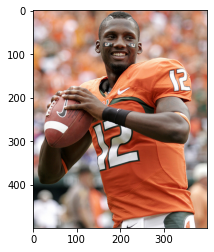

Greedy Search
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'playing', 'with', 'a', 'ball']
Correct Captions


['a football player wearing an orange jersey holding a football',
 'a football player wearing an orange uniform smiling and holding the football ',
 'a man in an orange jersey with the letter  12  on it plays football ',
 'a university of miami player holds a football ',
 'number 12 in orange gets ready to throw the football ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

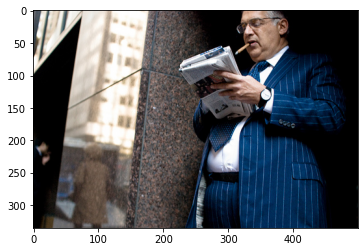

Greedy Search
['a', 'man', 'in', 'a', 'red', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'jacket', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black']
Correct Captions


['a man in a blue pinstriped suit is reading a newspaper while smoking a cigar',
 'a man in a blue suit reads the paper while smoking next to a marble building ',
 'a man is standing up  reading a newspaper  and smoking a cigar ',
 'a man smoking a cigar reading a paper in a city',
 'a man standing by a building corner and reading a newspaper ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

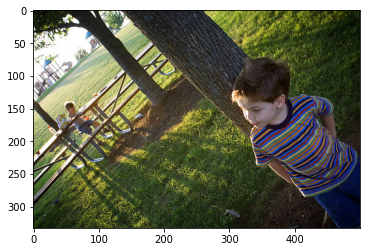

Greedy Search
['a', 'little', 'girl', 'in', 'a', 'red', 'shirt', 'is', 'sitting', 'on', 'a', 'swing']
Correct Captions


['a boy hiding behind a tree',
 'a boy in a striped tshirt is standing by a tree in front of the picnic tables ',
 'a little boy in a striped shirt is standing behind a tree ',
 'a young boy in a striped shirt is leaning against a tree while another child sits at a picnic table ',
 'two boys in a park  one standing near a tree and one sitting at a picnic table with the playground behind them ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

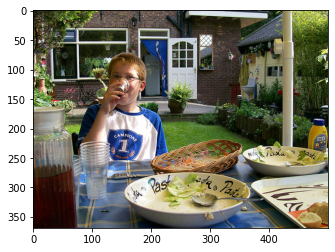

Greedy Search
['a', 'man', 'in', 'a', 'red', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black']
Correct Captions


['a young boy sits at a picnic table and drinks out of a small cup ',
 'boy drinking  at backyard table full of bowls of food ',
 'child sitting at a backyard picnic table ',
 'little boy is drinking out of a glass at a picnic ',
 'the boy drinks from a plastic glass while sitting at a table with food on it ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

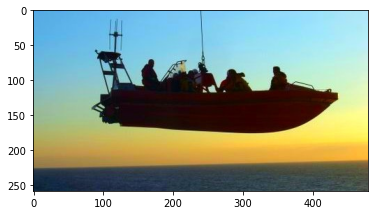

Greedy Search
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'the', 'water']
Correct Captions


['a boat containing people is suspended by a cable ',
 'a boat suspended by a cable over the water ',
 'a raft hanging from a rope over the ocean ',
 'a small group of people are in a small red boat and it is in the air over the ocean ',
 'the boat with passengers gets lifted out of the water by a large cable ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

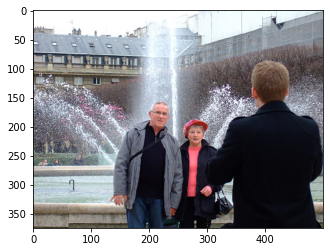

Greedy Search
['a', 'man', 'in', 'a', 'black', 'shirt', 'is', 'standing', 'in', 'a', '<unk>']
Correct Captions


['a couple is photographed in front of a large outdoor fountain ',
 'a couple pose in front of a fountain ',
 'an older couple posing in front of a fountain for a picture',
 'older couple posing for a picture in front of a fountain ',
 'the parents of the younger male are posing for a picture in front of a water fountain ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

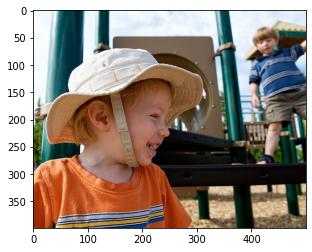

Greedy Search
['a', 'woman', 'in', 'a', 'red', 'shirt', 'is', 'sitting', 'on', 'a', '<unk>']
Correct Captions


['a boy with an orange shirt smiles  while a boy in a blue shirt looks on ',
 'a little boy in a tan hat on the ground of a play area ',
 'a smiling boy in an orange shirt with a safari hat sits at the playground  while a boy in a blue shirt looks on ',
 'boy in tan hat laughs while sitting near playground equipment ',
 'two boys  one wearing a hat  in a playground ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

In [ ]:
model.fit(xy_data, epochs=epochs, steps_per_epoch=steps)

1768/1768 [==============================] - 3059s 2s/step - loss: 2.9947


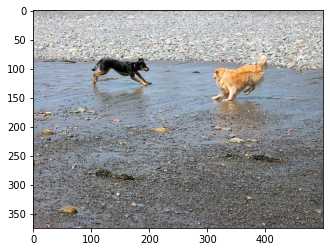

Greedy Search
['a', 'dog', 'is', 'running', 'through', 'the', 'grass']
Correct Captions


['a black dog and a golden dog approaching one another',
 'a black dog and tan dog run towards each other on a beach ',
 'a black dog is approaching a golden dog on pebbly beach ',
 'two dogs playing on a rocky beach ',
 'two dogs running on the sand ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

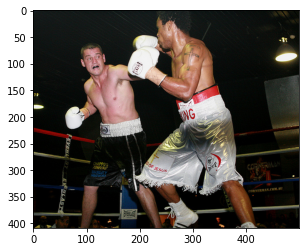

Greedy Search
['a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'black', 'shirt', 'is', 'playing', 'with', 'a', 'ball']
Correct Captions


['a boxer in black trunks taking a swing at a boxer in white trunks ',
 'a man in black shorts is boxing against and man in white shorts ',
 'a man wearing black boxing shorts and white boxing gloves and a man in white boxing shorts and white boxing gloves are fighting in the ring ',
 'two boxers fight in a welllit ring surrounded by poorlylit seating ',
 'two men battle it out in a boxing match with white gloves ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

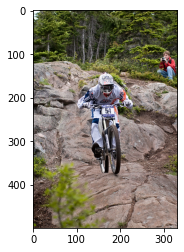

Greedy Search
['a', 'man', 'in', 'a', 'helmet', 'is', 'riding', 'a', 'bicycle', 'on', 'a', 'dirt', 'trail']
Correct Captions


['a dirt bike rider rides across the rock ',
 'a dirt bike rider takes an unconventional trail in a rocky area ',
 'a motocross bike is being ridden over rocks ',
 'a motorcycle rider on a path of rocks with a person holding a camera in the background with trees all around ',
 'a rider on motorcycle  riding over rocks ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

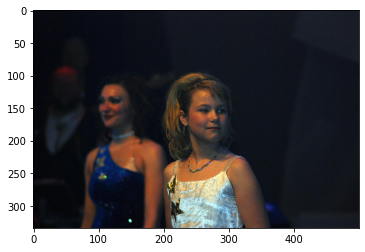

Greedy Search
['a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'black', 'shirt', 'and', 'a', 'woman', 'in', 'a', 'black', 'shirt']
Correct Captions


['a girl in a white dress walks next to a girl in a blue dress ',
 'a woman in a white dress and a woman in a blue dress onstage ',
 'a young girl with makeup and jewelry smiles ',
 'blonde girl in white top with stars standing beside brunette woman in blue top with stars ',
 'two teenage girls are wearing fancy dresses at an event ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

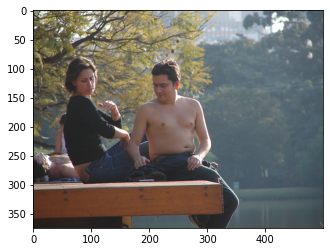

Greedy Search
['a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'black', 'pants', 'is', 'standing', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', '<unk>']
Correct Captions


['a lady and a man with no shirt sit on a dock ',
 'a man and a woman are sitting on a dock together ',
 'a man and a woman sitting on a dock ',
 'a man and woman sitting on a deck next to a lake ',
 'a shirtless man and a woman sitting on a dock ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

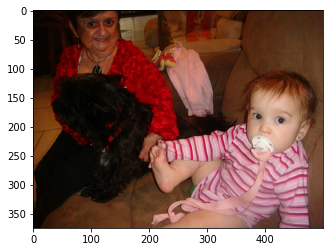

Greedy Search
['a', 'man', 'in', 'a', 'red', 'shirt', 'and', 'a', 'black', 'shirt', 'is', 'sitting', 'on', 'a', '<unk>']
Correct Captions


['a baby in pink  striped clothing is sitting near an older lady wearing red and black ',
 'a baby sitting next to a very old woman ',
 'a baby with a pink outfit on has a pacifier  and she is on a chair with another woman ',
 'a woman in a red shirt is holding a black dog on a brown sofa with a little girl wearing a striped onsie with a pacifier in her mouth ',
 'the baby sitting next to the black dog is sucking a pacifier ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

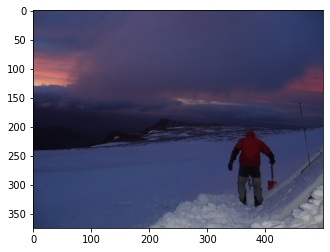

Greedy Search
['a', 'man', 'in', 'a', 'red', 'jacket', 'is', 'standing', 'on', 'a', 'snowy', 'hill']
Correct Captions


['a man is shoveling snow during a sunrise ',
 'a man stands in the snow as the sun sets ',
 'a mist overshadows a man in winter gear and the winter landscape in front of him ',
 'a person stands in a snowy area looking down ',
 'man walking through the deep snow at dusk ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

In [ ]:
model.save("/content/drive/MyDrive/MODELS/keras_image_captioning1.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.fit(xy_data, epochs=epochs, steps_per_epoch=steps)

1768/1768 [==============================] - 3076s 2s/step - loss: 2.7996


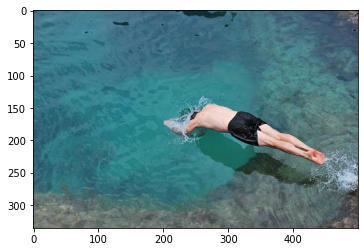

Greedy Search
['a', 'boy', 'in', 'a', 'wetsuit', 'is', 'jumping', 'into', 'a', 'pool']
Correct Captions


['a man dives into a clear blue lake ',
 'a man in black bathing trunks dives into water ',
 'a man in black shorts is diving into a rocky pool ',
 'a man in black swim trunks diving into the water',
 'a person is diving into clear blue water ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

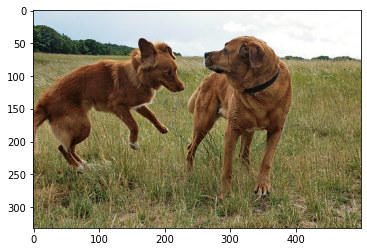

Greedy Search
['a', 'brown', 'dog', 'is', 'running', 'through', 'the', 'grass']
Correct Captions


['a dog hops in a field while another dog stands next to it ',
 'one dog is jumping up at another dog in a grassy field ',
 'the two tan colored dogs are in a field  and one is jumping in the air ',
 'two brown dogs in a field ',
 'two brown dogs play with one another in the field ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

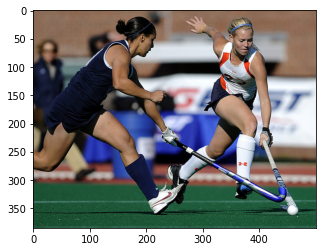

Greedy Search
['a', 'boy', 'in', 'a', 'red', 'shirt', 'is', 'playing', 'with', 'a', 'ball']
Correct Captions


['two girls are fighting over a ball during a game ',
 'two woman competing in a sporting event',
 'two women are playing a game with sticks and a small white ball ',
 'two women are reaching with sticks for a ball during a sports game ',
 'two women playing field hockey ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

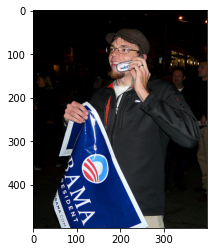

Greedy Search
['a', 'man', 'in', 'a', 'black', 'coat', 'and', 'a', 'black', 'jacket', 'is', 'standing', 'in', 'front', 'of', 'a', '<unk>']
Correct Captions


['a man talking on a cellphone is holding a blue banner ',
 'a man talks on a cellphone while holding an obama campaign sign ',
 'the man in glasses carrying an obama poster is talking on a cellphone ',
 'the obama supporter wears a black jacket and brown hat ',
 'yong man with cellphone and goatee holding obama sign']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

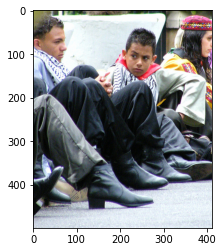

Greedy Search
['a', 'man', 'and', 'a', 'woman', 'are', 'sitting', 'on', 'a', 'bench']
Correct Captions


['a boy looks suspiciously at someone nearby ',
 'a group of people sit on pavement wearing dark shoes and warm clothes ',
 'a row of legs and black boots with a boy sitting at the end of the row ',
 'a row of people sitting on the ground wearing matching heeled boots ',
 'the young man is waiting with others on the sidewalk ']

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")

img=preprocess_img(img_path)
input_img=inception_wo_classification.predict(img)
caption=[]
input_seq=["<start>"]+["<pad>" for _ in range(max_cap_len-1)]
input_seq=np.expand_dims(np.array(list(map(lambda word:word2idx_dic[word], input_seq))), 0)
i=1
while i<max_cap_len:
    pred_idx=np.argmax(model.predict([input_img, input_seq]))
    word=idx2word_dic[pred_idx]
    if word =="<end>":
        break
    caption.append(word)
    input_seq[0, i]=word2idx_dic[word]
    i+=1

print(caption)
# print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

In [ ]:
model.save("/content/drive/MyDrive/MODELS/keras_image_captioning2.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.fit(xy_data, epochs=epochs, steps_per_epoch=steps)
model.save("/content/drive/MyDrive/MODELS/keras_image_captioning3.h5")

In [ ]:
img_path=test_imgs_path[np.random.randint(0, len(test_imgs_path))]
x=plt.imread(images_path+img_path)
plt.imshow(x)
plt.show()
print("Greedy Search")
print(greedy_search(img_path))
print("Correct Captions")
desc_dic[img_path]

In [ ]:
model.load("/content/drive/MyDrive/MODELS/keras_image_captioning4.h5")
model.fit(xy_data, epochs=epochs, steps_per_epoch=steps)
model.save("/content/drive/MyDrive/MODELS/keras_image_captioning5.h5")

In [ ]:
# def generator(imgs_paths, seqs, batch_size, max_len):
#     if len(imgs_paths)%batch_size!=0:
#         print("change batch size")
#         return
#     iter=0
#     while True:
#         img_batch=[]
#         seq_batch=[]
#         answer_seq_batch=[]
#         gen_order=np.arange(len(imgs_paths))
#         np.random.shuffle(gen_order)
#         gen_order=np.reshape(gen_order, [-1, batch_size])
#         for i in range(gen_order.shape[0]):
#             for idx in gen_order[i, :]:
#                 img_array=inception_wo_classification.predict(preprocess_img(imgs_paths[idx]))[0, :]
#                 for j in range(1, len(seqs[idx])):
#                     img_batch.append(img_array)
#                     seq_batch.append(seqs[idx][:j])
#                     answer_seq_batch.append(seqs[idx][j])

#                     iter+=1
#                     if iter&==0:
#                         yield ([np.array(img_batch), pad_sequences(seq_batch, maxlen=max_len)], to_categorical(answer_seq_batch, num_classes=vocab_size))
#                         img_batch=[]
#                         seq_batch=[]
#                         answer_seq_batch=[]                        

In [ ]:
# inception_wo_classification.predict(preprocess_img(train_imgs_path[0])).shape

In [ ]:
# a=next(xy_data)

KeyboardInterrupt: ignored

In [ ]:
# lines=[]
# for img, desc_list in desc_dic.items():
#     for desc in desc_list:
#         lines.append(img+"  "+desc)
# new_token_text="\n".join(lines)

In [ ]:
# vocab_size=1500
# tokenizer=Tokenizer(num_words=vocab_size-1, oov_token="<unk>")
# tokenizer.word_index['<pad>'] = 0
# tokenizer.index_word[0] = '<pad>'
# tokenizer.fit_on_texts(train_caps)

In [ ]:
# tokenizer=Tokenizer(oov_token="<unk>")
# tokenizer.word_index=word2idx_dic
# tokenizer.word_index['<pad>'] = 0
# tokenizer.index_word[0] = '<pad>'

In [ ]:
# train_seq=tokenizer.texts_to_sequences(train_caps)

In [ ]:
# vocab_size=len(tokenizer.word_index)+1

In [ ]:
# train_imgs=[]
# for img in train_imgs_path:
#     img_array=preprocess(img)
#     train_imgs.append(img_array)
# train_imgs=np.array(train_imgs)

# test_imgs=[]
# for img in test_imgs_path:
#     img_array=preprocess(img)
#     test_imgs.append(img_array)
# test_imgs=np.array(test_imgs)